### traj_5730-5760_0005692105-325020080826

In [1]:
# eddy arguments
eddy_code = 'traj_5730-5760_0005692105'
eddy_list = [1, 2, 3, 4, 5, 6, 7, 8]

In [2]:
# expo arguments
expo_code = '325020080826'
expo_list = '/home/cz2397/data/cchdo-ctd/741_325020080826_nc_ctd/*_ctd.nc'

In [3]:
# eddy-expo arguments
STA = '032'
CAS = '01'

In [4]:
# packages
from ctd2xray import cchdo
from geopy.distance import great_circle
from mpl_toolkits.basemap import Basemap
from pymongo import MongoClient
import gsw
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
%matplotlib inline

In [5]:
# longitude
def range_180(longitude):
    if longitude < 180:
        longitude = longitude
    else:
        longitude = longitude - 360
    return longitude

In [6]:
# eddy
rcs_eddies = MongoClient().eddies.rcs_eddies
eddy_rclv = rcs_eddies.find_one({'_id': eddy_code})
eddy_area = eddy_rclv['area']
eddy_radius_meter = (eddy_area/np.pi)**0.5
earth_radius_meter = 6371000
eddy_radius_degree = 180*eddy_radius_meter/(np.pi*earth_radius_meter)
eddy_traj = eddy_rclv['features'][2]['geometry']['coordinates']
obs_num = len(eddy_traj)
lon_eddy = np.zeros(obs_num)
lat_eddy = np.zeros(obs_num)
for i in range(obs_num):
    lon_eddy[i] = range_180(eddy_traj[i][0])
    lat_eddy[i] = eddy_traj[i][1]
lon_eddy_mean = lon_eddy.mean()
lat_eddy_mean = lat_eddy.mean()
lon_ee = np.zeros(len(eddy_list))
lat_ee = np.zeros(len(eddy_list))
for i in range(len(eddy_list)):
    lon_ee[i] = range_180(eddy_traj[eddy_list[i]-1][0])
    lat_ee[i] = eddy_traj[eddy_list[i]-1][1]
lon_ee_mean = lon_ee.mean()
lat_ee_mean = lat_ee.mean()

In [7]:
# expo
cchdo_ctd = MongoClient().eddies.cchdo_ctd
cas_num = cchdo_ctd.find({'expocode': expo_code}).count()
lon_expo = np.zeros(cas_num)
lat_expo = np.zeros(cas_num)
i = 0
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    lon_expo[i] = expo['location']['coordinates'][0]
    lat_expo[i] = expo['location']['coordinates'][1]
    i = i+1

** figure 1 | global location**

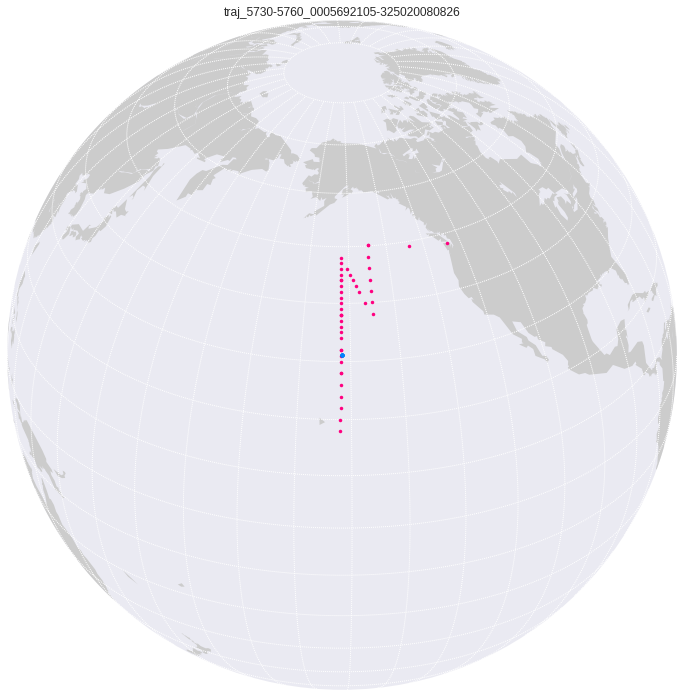

In [8]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
my_map = Basemap(projection='ortho', resolution='c',\
                 lon_0=lon_eddy_mean, lat_0=lat_eddy_mean)
my_map.drawmapboundary('none')
my_map.drawparallels(np.arange(-90, 90, 10), color='#ffffff')
my_map.drawmeridians(np.arange(0, 360, 10), color='#ffffff')
my_map.fillcontinents()
x_eddy, y_eddy = my_map(lon_eddy, lat_eddy)
x_expo, y_expo = my_map(lon_expo, lat_expo)
my_map.plot(x_eddy, y_eddy, '.', color='#0080ff', zorder=20)
my_map.plot(x_expo, y_expo, '.', color='#ff0080', zorder=10)
plt.title(eddy_code + '-' + expo_code)
plt.savefig('figures/figure-1/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** figure 2 | regional location **

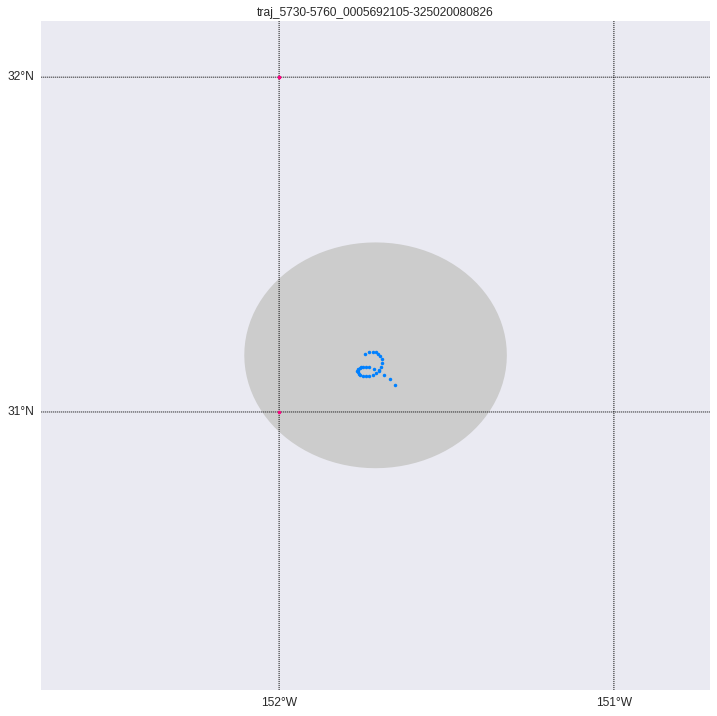

In [9]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
my_map = Basemap(projection='cyl', resolution='c',\
                 llcrnrlat=lat_ee_mean-1, urcrnrlat=lat_ee_mean+1,\
                 llcrnrlon=lon_ee_mean-1, urcrnrlon=lon_ee_mean+1)
my_map.tissot(lon_0=lon_ee_mean, lat_0=lat_ee_mean, radius_deg=eddy_radius_degree,\
              npts=100, fc='#cccccc', ec='none', zorder=1)
my_map.fillcontinents()
my_map.drawparallels(np.arange(-90, 90, 1), labels=[1,0,0,0])
my_map.drawmeridians(np.arange(0, 360, 1), labels=[0,0,0,1])
x_eddy, y_eddy = my_map(lon_eddy, lat_eddy)
x_expo, y_expo = my_map(lon_expo, lat_expo)
my_map.plot(x_eddy, y_eddy, '.', color='#0080ff')
my_map.plot(x_expo, y_expo, '.', color='#ff0080')
plt.title(eddy_code + '-' + expo_code)
plt.savefig('figures/figure-2/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** figure 3 | temperature-salinity **

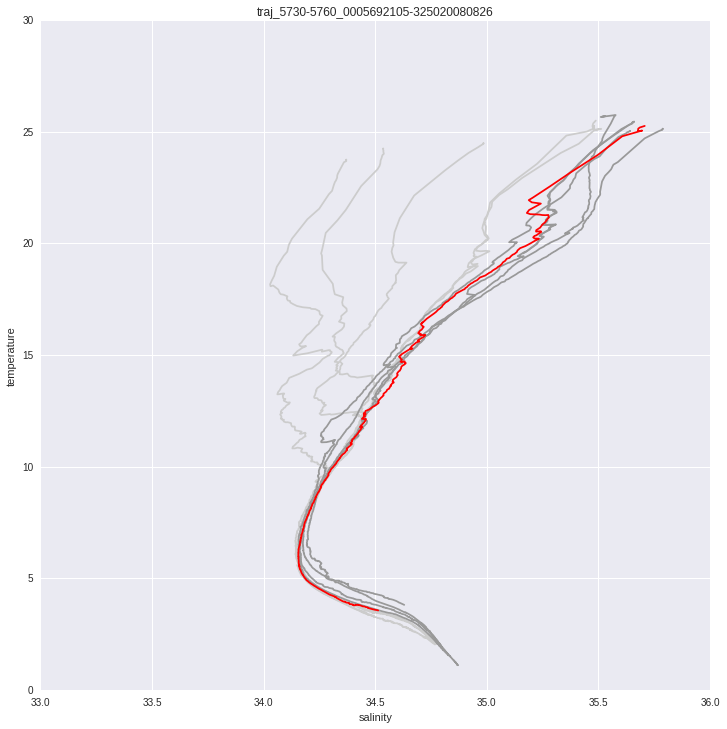

In [10]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values 
    t = ds.temperature.values
    s_original = ds.CTDSAL.values
    s_masked = np.ma.masked_less(s_original, 0)
    ds.CTDSAL.values = s_masked
    s = ds.CTDSAL.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = str(ds.STATION_NUMBER)
    cast = str(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        LON = lon
        plt.plot(sa, ct, color='#ff0000', zorder=3)
    elif station in ['028', '029', '030', '031']:
        plt.plot(sa, ct, color='#cccccc', zorder=1)
    elif station in ['033', '034', '035', '036']:
        plt.plot(sa, ct, color='#999999', zorder=2)
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('salinity')
plt.xlim([33, 36])
plt.ylabel('temperature')
plt.savefig('figures/figure-3/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** figure 4 | pressure-temperature **

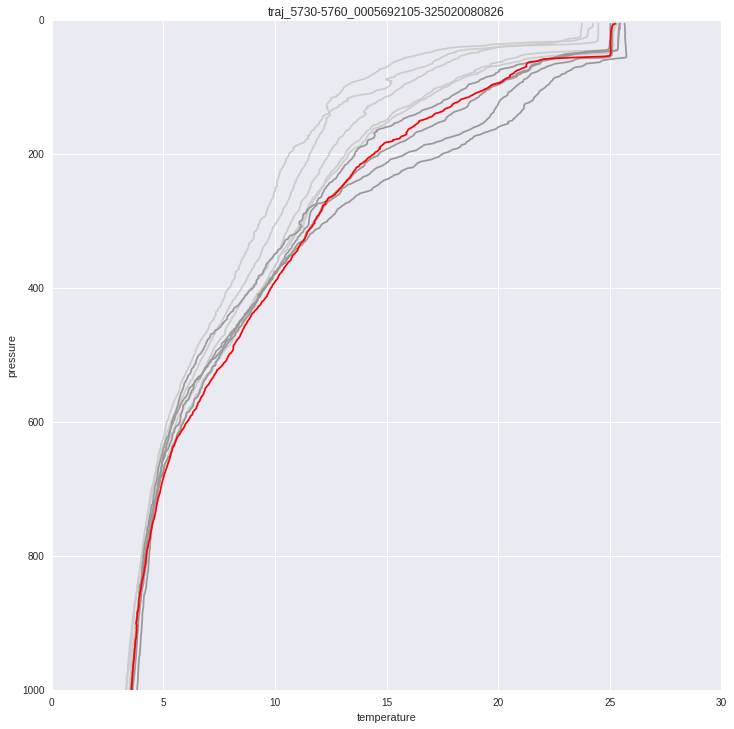

In [11]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    t = ds.temperature.values
    s = ds.CTDSAL.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    ct = gsw.CT_from_t(sa, t, p)
    station = str(ds.STATION_NUMBER)
    cast = str(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        plt.plot(ct, p, color='#ff0000', zorder=3)
    elif station in ['028', '029', '030', '031']:
        plt.plot(ct, p, color='#cccccc', zorder=1)
    elif station in ['033', '034', '035', '036']:
        plt.plot(ct, p, color='#999999', zorder=2)
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('temperature')
plt.ylabel('pressure')
plt.ylim([1000, 0])
plt.savefig('figures/figure-4/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** figure 5 | pressure-salinity **

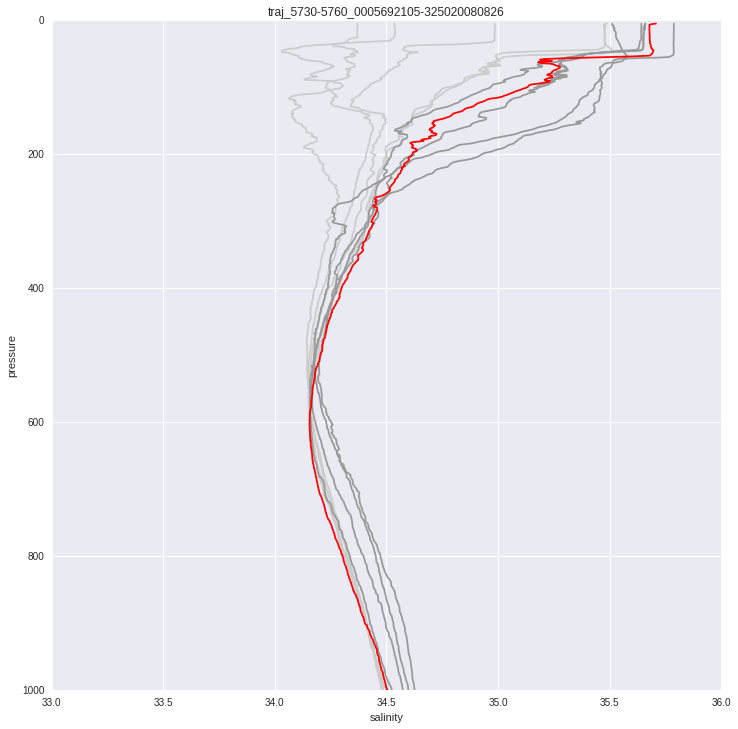

In [12]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    lon = ds.longitude.values[0]
    lat = ds.latitude.values[0]
    p = ds.pressure.values
    s = ds.CTDSAL.values
    sa = gsw.SA_from_SP(s, p, lon, lat)
    station = str(ds.STATION_NUMBER)
    cast = str(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        plt.plot(sa, p, color='#ff0000', zorder=3)
    elif station in ['028', '029', '030', '031']:
        plt.plot(sa, p, color='#cccccc', zorder=1)
    elif station in ['033', '034', '035', '036']:
        plt.plot(sa, p, color='#999999', zorder=2)
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('salinity')
plt.xlim([33, 36])
plt.ylabel('pressure')
plt.ylim([1000, 0])
plt.savefig('figures/figure-5/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** figure 6 | pressure-oxygen **

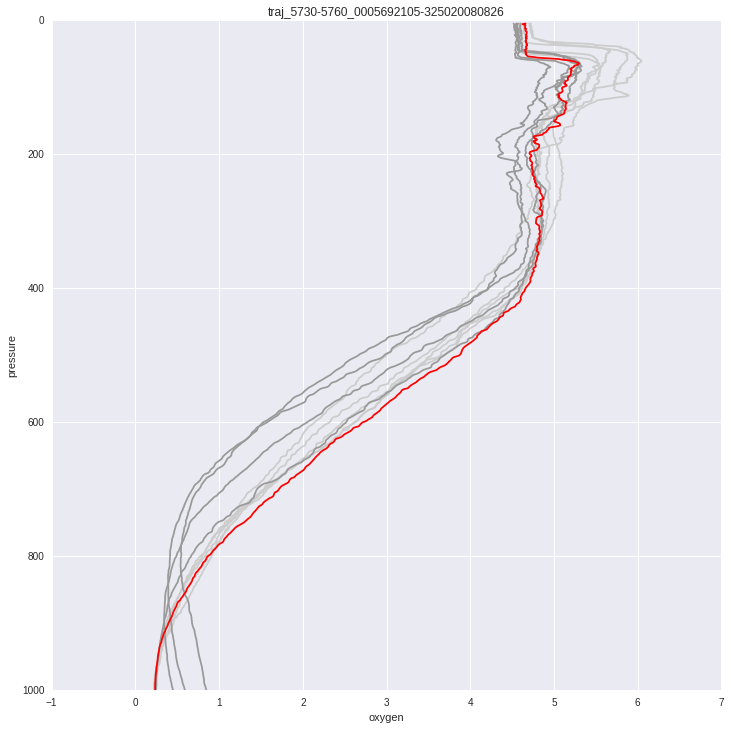

In [13]:
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)
for expo in cchdo_ctd.find({'expocode': expo_code}).sort('time', 1):
    ds = xr.open_dataset(expo['path'])
    p = ds.pressure.values
    o = ds.CTDOXY.values
    station = str(ds.STATION_NUMBER)
    cast = str(ds.CAST_NUMBER)
    if station == STA and cast == CAS:
        plt.plot(o, p, color='#ff0000', zorder=3)
    elif station in ['028', '029', '030', '031']:
        plt.plot(o, p, color='#cccccc', zorder=1)
    elif station in ['033', '034', '035', '036']:
        plt.plot(o, p, color='#999999', zorder=2)
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('oxygen')
plt.ylabel('pressure')
plt.ylim([1000, 0])
plt.savefig('figures/figure-6/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

In [14]:
# section
pressure = np.linspace(0, 6000, num=6001, endpoint=True)
ds_tim = cchdo.open_cchdo_as_mfdataset(expo_list, pressure)
longitude = ds_tim.longitude.values
latitude = ds_tim.latitude.values
distance = np.zeros(len(ds_tim.time.values))
for i in range(1, len(distance)):
    origin = (latitude[i-1], longitude[i-1])
    termination = (latitude[i], longitude[i])
    distance[i] = great_circle(origin, termination).kilometers
dis_cum = np.cumsum(distance)
dis_index = ds_tim.longitude.values.tolist().index(LON)
DIS = dis_cum[dis_index]
dis_cum_reset = dis_cum - DIS
ds_tim['distance'] = xr.DataArray(dis_cum_reset, dims=ds_tim.time.dims, coords=ds_tim.time.coords)
ds_dis = ds_tim.swap_dims({'time': 'distance'})
ds_dis_subset = ds_dis.sel(pressure_i=slice(0, 500), distance=slice(-600, 600))

** figure 7 | temperature section **

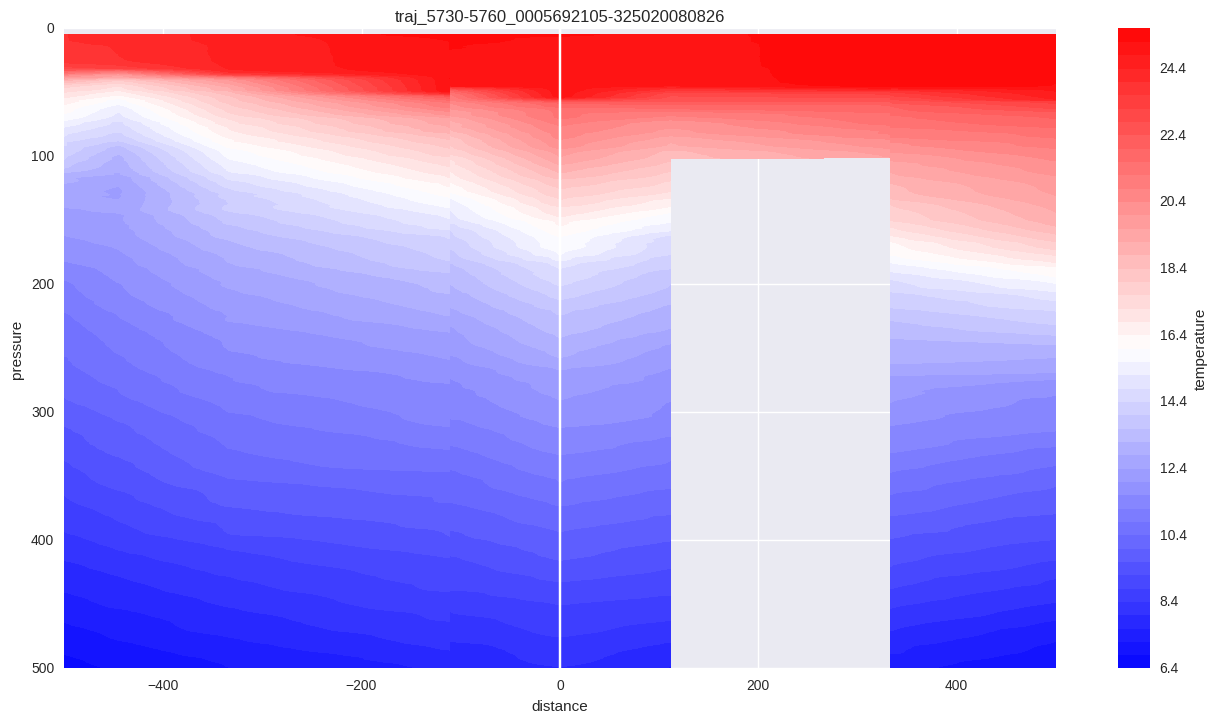

In [18]:
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
image = ds_dis_subset.temperature_i.T.plot.contourf(cmap='bwr', levels=50)
image.colorbar.set_label('temperature')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('distance')
plt.xlim([-500, 500])
plt.ylabel('pressure')
plt.ylim([500, 0])
plt.axvline(0, color='#ffffff')
plt.savefig('figures/figure-7/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** figure 8 | salinity section **

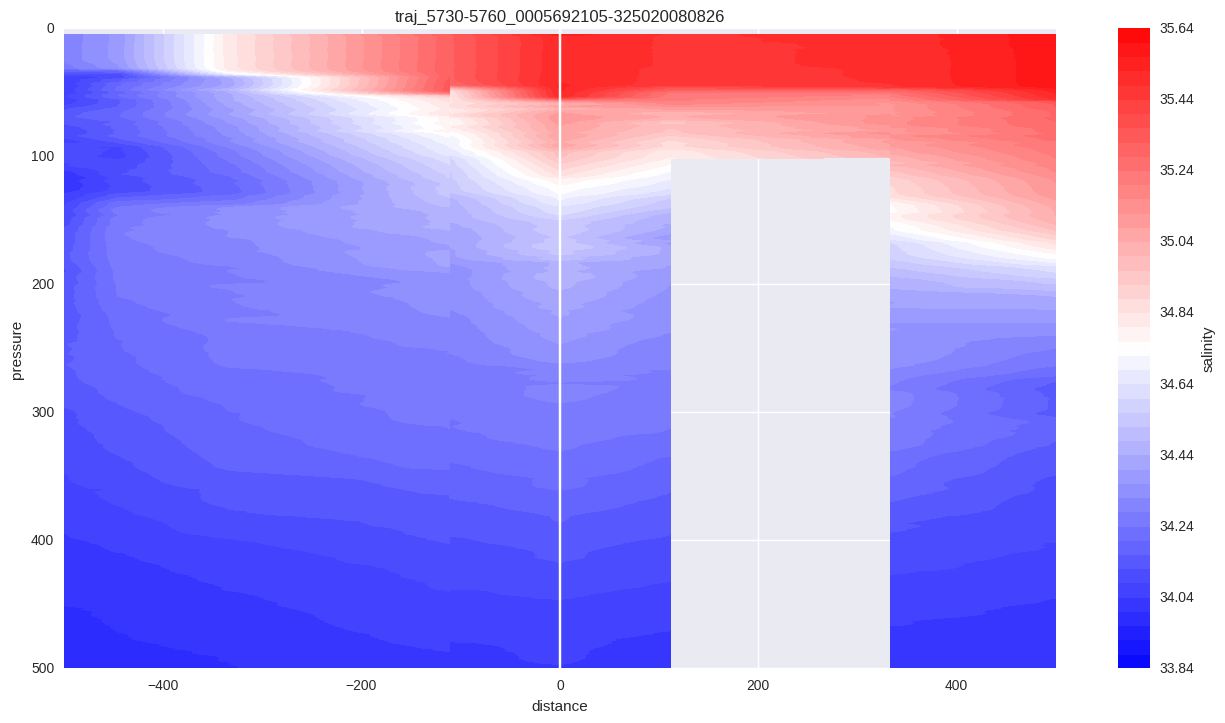

In [16]:
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
image = ds_dis_subset.CTDSAL_i.T.plot.contourf(cmap='bwr', levels=50)
image.colorbar.set_label('salinity')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('distance')
plt.xlim([-500, 500])
plt.ylabel('pressure')
plt.ylim([500, 0])
plt.axvline(0, color='#ffffff')
plt.savefig('figures/figure-8/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()

** figure 9 | oxygen section **

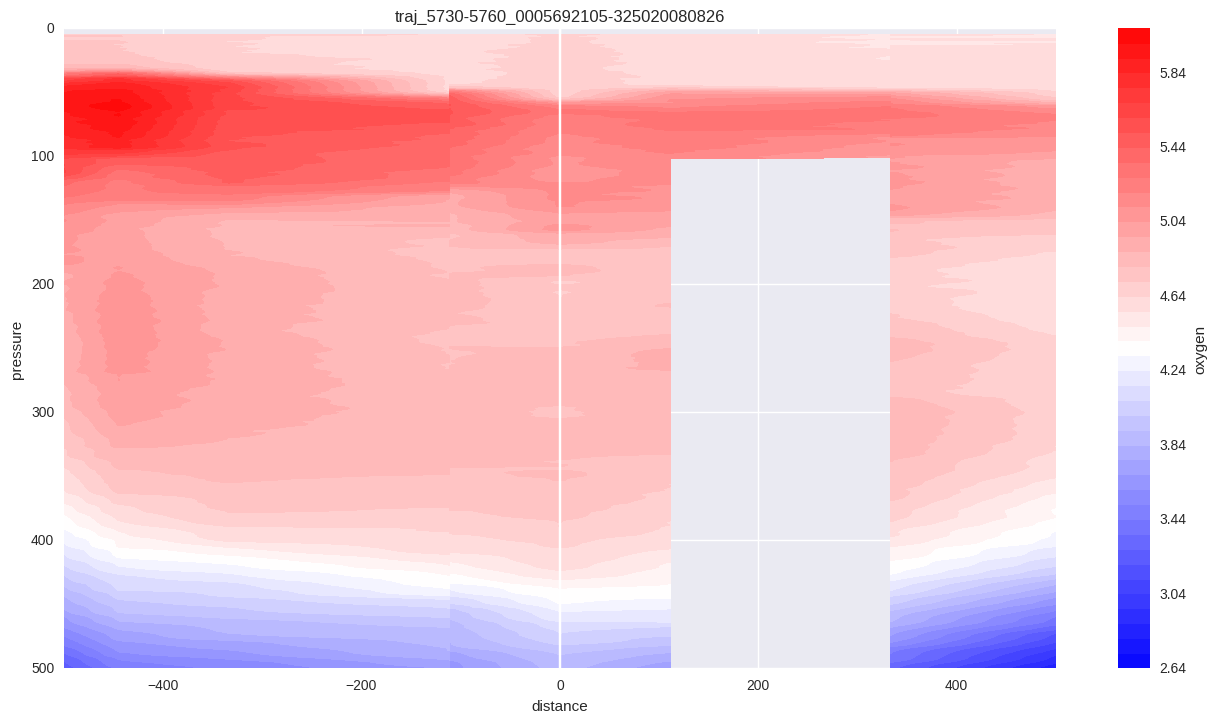

In [17]:
sns.set()
plt.rcParams['figure.figsize'] = (16, 8)
image = ds_dis_subset.CTDOXY_i.T.plot.contourf(cmap='bwr', levels=50)
image.colorbar.set_label('oxygen')
plt.title(eddy_code + '-' + expo_code)
plt.xlabel('distance')
plt.xlim([-500, 500])
plt.ylabel('pressure')
plt.ylim([500, 0])
plt.axvline(0, color='#ffffff')
plt.savefig('figures/figure-9/' + eddy_code + '-' + expo_code + '.jpeg')
plt.show()